In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as pl
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import os
import math 
from matplotlib.dates import MonthLocator, DateFormatter

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2

import optuna


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def objective_lstm(trial):
    
    units_layer = trial.suggest_int('units_layer', 1, 200) # number of neurons
    learning_rate = trial.suggest_uniform('learning_rate',0.0001,0.1)
    batch_size = trial.suggest_categorical('batch_size',[4,8,16, 32, 64, 128, 256,512])
    # num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout_rate = trial.suggest_float('dropout_rate_'+str(i+1),0,0.5,log=False)
    l2_reg = trial.suggest_float('l2_reg', 0, 0.1)

    
    model = Sequential([
                    layers.LSTM(units=units_layer,input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),dropout=dropout_rate,kernel_regularizer=l2(l2_reg),return_sequences=False),
                    #layers.LSTM(units=units_layer,dropout=dropout_rate,kernel_regularizer=l2(l2_reg),return_sequences=False),
                    layers.Dense(n_ahead)])

    # Assuming you have one output dimension, adjust accordingly
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

    early_stopping_callback = EarlyStopping(
        monitor='val_loss',  # or another metric you want to monitor
        patience=30,  # number of epochs with no improvement after which training will be stopped
        mode='min',
        restore_best_weights=True,  # 'min' or 'max': minimize the quantity monitored or maximize it
        verbose=0  # 0: quiet, 1: update messages
    )
    model.fit(X_train_scaled, y_train, epochs=500,verbose=0,validation_data=(X_val_scaled,y_val),batch_size=batch_size, callbacks=[early_stopping_callback])
    
    test_predictions = model.predict(X_test_scaled)
    y_test_1 = y_test.reshape(len(y_test),-1)
    mae_per_column = np.mean(np.abs(y_test_1- test_predictions), axis=0)
    total_mae = sum(mae_per_column) / len(mae_per_column)

    # test_loss,mae = model.evaluate(X_test_scaled, y_test)

    return total_mae


# Many to Many

In [102]:
n_ahead=10
timesteps = 3

cwd = os.getcwd()
df_hist = pd.read_csv(cwd + '/datos_TFM_Celia.csv', sep = ',', engine='python')
df_hist['Time'] = pd.to_datetime(df_hist['Time'])
df_hist.set_index('Time',inplace=True)

for i in range(1, n_ahead+1):
    df_hist[f'ws_lead{i}'] = df_hist['ws'].shift(-i)
for i in range(1, n_ahead+1):
    df_hist[f'wd_lead{i}'] = df_hist['wd'].shift(-i)
df_hist.dropna(inplace=True)

INPUTS = ['Power','wd','ws'] + [f'ws_lead{i}' for i in range(1, n_ahead+1)]+ [f'wd_lead{i}' for i in range(1, n_ahead+1)]
OUTPUT = ['Power']

X_orig = df_hist[INPUTS]
y_orig = df_hist[OUTPUT]

n_features=X_orig.shape[1]

np_X=X_orig.to_numpy()
np_y=y_orig.to_numpy()
X=[]
y=[]

for i in range(len(np_X)-timesteps-n_ahead):
    row = [[a] for a in np_X[i:i+timesteps]]
    X.append(row)
    label = np_y[i+timesteps:i+timesteps+n_ahead]
    y.append(label)

X,y=np.array(X), np.array(y)
X=X.reshape(X.shape[0],timesteps,n_features)

q_30 = int(len(X) * .3)
q_50 = int(len(X) * .5)
X_train, y_train =  X[:q_30], y[:q_30]
X_val, y_val =  X[q_30:q_50], y[q_30:q_50]
X_test, y_test =  X[q_50:], y[q_50:]

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(len(X_train),-1))
X_train_scaled = X_train_scaled.reshape(len(X_train),timesteps,n_features)

X_val_scaled = scaler.fit_transform(X_val.reshape(len(X_val),-1))
X_val_scaled = X_val_scaled.reshape(len(X_val),timesteps,n_features)

X_test_scaled = scaler.transform(X_test.reshape(len(X_test),-1))
X_test_scaled = X_test_scaled.reshape(len(X_test),timesteps,n_features)


### Optimizar hiperparámetros

In [ ]:
study = optuna.create_study(direction='minimize')  # minimizing mean squared error
study.optimize(objective_lstm, n_trials=100) #trials=100
print(study.best_params) 

### Entrenamiento

In [103]:
units_layer = 50
learning_rate = 0.029867957296936466
batch_size = 256
dropout_rate = 0.002155400757519615
l2_reg = 0.038310264254144764

model = Sequential([
                    layers.LSTM(units=units_layer,input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),dropout= dropout_rate, kernel_regularizer=l2(l2_reg), return_sequences=False),
                    layers.Dense(n_ahead)])
lr= learning_rate
model.compile(loss='mse', 
              optimizer=Adam(lr=lr),
              metrics=['mean_absolute_error'])

history=model.fit(X_train_scaled, y_train, epochs=1000,validation_data=(X_val_scaled,y_val),batch_size=batch_size)

# Compute baseline performance metric
baseline_loss = model.evaluate(X_val_scaled, y_val)[0]

Epoch 1/1000
21/21 [==============================] - 2s 19ms/step - loss: 1.4735 - mean_absolute_error: 0.2634 - val_loss: 1.1867 - val_mean_absolute_error: 0.2341
Epoch 2/1000
21/21 [==============================] - 0s 10ms/step - loss: 0.9700 - mean_absolute_error: 0.2058 - val_loss: 0.7866 - val_mean_absolute_error: 0.2157
Epoch 3/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.6408 - mean_absolute_error: 0.1936 - val_loss: 0.5209 - val_mean_absolute_error: 0.2017
Epoch 4/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.4213 - mean_absolute_error: 0.1808 - val_loss: 0.3450 - val_mean_absolute_error: 0.1858
Epoch 5/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.2773 - mean_absolute_error: 0.1692 - val_loss: 0.2299 - val_mean_absolute_error: 0.1734
Epoch 6/1000
21/21 [==============================] - 0s 4ms/step - loss: 0.1845 - mean_absolute_error: 0.1601 - val_loss: 0.1569 - val_mean_absolute_error: 0.1645
Epoch 7/1000
2

In [105]:
print("Número de parámetros ajustados en el modelo LSTM:", model.count_params())


Número de parámetros ajustados en el modelo LSTM: 15310


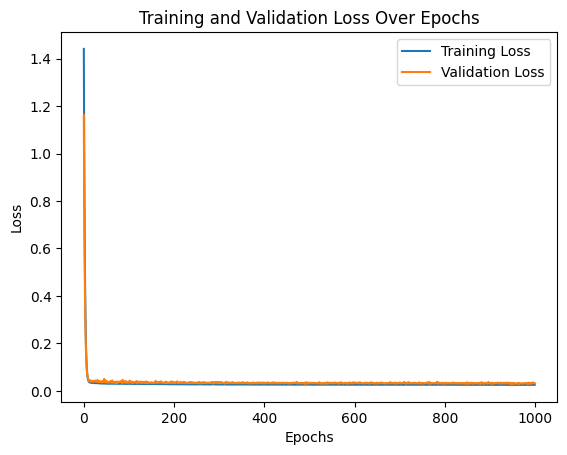

Epoch at Minimum Training Loss: 970
Minimum Training Loss: 0.024743670597672462
Epoch at Minimum Validation Loss: 946
Minimum Validation Loss: 0.028291184455156326


In [78]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
min_loss_epoch = np.argmin(loss_values)
min_loss_value = loss_values[min_loss_epoch]
min_val_loss_epoch = np.argmin(val_loss_values)
min_val_loss_value = val_loss_values[min_val_loss_epoch]
print("Epoch at Minimum Training Loss:", min_loss_epoch)
print("Minimum Training Loss:", min_loss_value)
print("Epoch at Minimum Validation Loss:", min_val_loss_epoch)
print("Minimum Validation Loss:", min_val_loss_value)

### Prueba

In [79]:
test_predictions = model.predict(X_test_scaled)
y_test_1 = y_test.reshape(len(y_test),-1)
mae_per_column = np.mean(np.abs(y_test_1- test_predictions), axis=0)
list(mae_per_column) 

274/274 [==============================] - 0s 462us/step


[0.06629707956147417,
 0.09050115386683483,
 0.10587245633629498,
 0.11653146934160089,
 0.12467613407488963,
 0.1319015311056081,
 0.137425977941861,
 0.14240325939922743,
 0.14638924095793743,
 0.15190792864434532]

In [80]:
column_names = [f"+{i+1}h" for i in range(n_ahead)]
df_test_preds = pd.DataFrame(test_predictions, columns=column_names)
df_test_preds.index = df_hist.index[q_50:-(timesteps+n_ahead)].values

In [81]:
test_preds_matrix = pd.DataFrame()

for i in range(n_ahead):
    shifted_predictions = df_test_preds.iloc[:, i].shift(i)
    test_preds_matrix[f'+{1+i}h'] = shifted_predictions

test_preds_matrix.index = df_test_preds.index
test_preds_matrix['Power'] = y_test[:, 0, 0]


In [82]:
df_resultados = test_preds_matrix.dropna()
error_list = []

for i in range(1, n_ahead+1):
    column_name = f'+{i}h'
    mae_a = mean_absolute_error(df_resultados['Power'], df_resultados[column_name])
    rmse_a = math.sqrt(mean_squared_error(df_resultados['Power'], df_resultados[column_name]))
    
    error_list.append({'Horizon': i, 'MAE ': mae_a, 'RMSE ': rmse_a})

# Convertir la lista de diccionarios a DataFrame
df_comp_error = pd.DataFrame(error_list)
df_comp_error

Horizon      MAE      RMSE 
0        1  0.066330  0.097849
1        2  0.090554  0.130679
2        3  0.105935  0.150580
3        4  0.116605  0.163998
4        5  0.124752  0.174230
5        6  0.131993  0.183990
6        7  0.137521  0.191061
7        8  0.142498  0.197200
8        9  0.146488  0.201882
9       10  0.152023  0.208522

In [83]:
df_comp_error.to_csv('LSTM_many_Resultados.csv', index=False)

In [92]:
df_resultados

+1h       +2h       +3h       +4h       +5h  \
2012-12-31 07:00:00  0.115246  0.090016  0.079113  0.073150  0.079313   
2012-12-31 08:00:00  0.072134  0.100259  0.080934  0.069858  0.064569   
2012-12-31 09:00:00  0.047192  0.064328  0.088329  0.071093  0.062389   
2012-12-31 10:00:00  0.044321  0.044639  0.058237  0.076624  0.061945   
2012-12-31 11:00:00  0.045154  0.042909  0.042742  0.050551  0.064874   
...                       ...       ...       ...       ...       ...   
2013-12-30 15:00:00 -0.007125  0.019744  0.010717  0.010475  0.029336   
2013-12-30 16:00:00 -0.007075  0.005436  0.014389  0.012362  0.015938   
2013-12-30 17:00:00  0.004587  0.003466  0.001844  0.021869  0.018824   
2013-12-30 18:00:00 -0.019275  0.011876 -0.000654  0.009896  0.032812   
2013-12-30 19:00:00 -0.016248 -0.007844  0.005906  0.006452  0.020383   

                          +6h       +7h       +8h       +9h      +10h  \
2012-12-31 07:00:00  0.047931  0.041631  0.071891  0.103869  0.094686   
2012-12-31 08:00:00  0.069267  0.041167  0.043148  0.077658  0.104887   
2012-12-31 09:00:00  0.058007  0.062326  0.036335  0.047775  0.075031   
2012-12-31 10:00:00  0.055788  0.055304  0.053670  0.034994  0.043098   
2012-12-31 11:00:00  0.053888  0.053693  0.050110  0.053367  0.031155   
...                       ...       ...       ...       ...       ...   
2013-12-30 15:00:00  0.022406  0.025023  0.019651  0.013100  0.011175   
2013-12-30 16:00:00  0.026347  0.024956  0.028383  0.023484  0.016638   
2013-12-30 17:00:00  0.013720  0.030217  0.030867  0.033668  0.031469   
2013-12-30 18:00:00  0.018527  0.016774  0.038773  0.036383  0.042499   
2013-12-30 19:00:00  0.033468  0.021753  0.026923  0.045792  0.046176   

                        Power  
2012-12-31 07:00:00  0.083451  
2012-12-31 08:00:00  0.065595  
2012-12-31 09:00:00  0.059581  
2012-12-31 10:00:00  0.052157  
2012-12-31 11:00:00  0.049995  
...                       ...  
2013-12-30 15:00:00  0.000000  
2013-12-30 16:00:00  0.000000  
2013-12-30 17:00:00  0.000000  
2013-12-30 18:00:00  0.000000  
2013-12-30 19:00:00  0.000000  

[8749 rows x 11 columns]

In [91]:
horizonte_prediccion = 1
column_name = f'+{horizonte_prediccion}h'

df_plot = pd.DataFrame()
df_plot['Time'] = df_resultados.index
df_plot['Prediction'] = df_resultados[column_name].values
df_plot['Power'] = df_resultados['Power'].values

fig = pl.line(df_plot, x='Time', y=['Power', 'Prediction'])
fig.show()

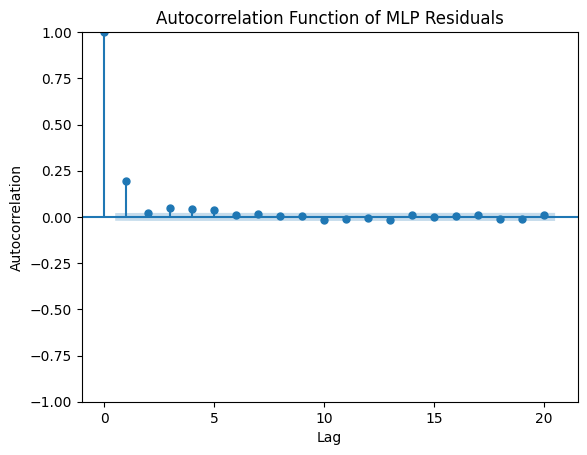

In [93]:
# Obtener residuos del modelo MLP
residuals = df_plot['Power'] - df_plot['Prediction']

# Calcular la función de autocorrelación de los residuos
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of MLP Residuals')
plt.show()

# Many to One

In [99]:
timesteps=3
n_ahead = 1 # tamaño salida LSTM (no cambiar)

#{'units_layer': 86, 'learning_rate': 0.0018091905426846529, 'batch_size': 512, 'dropout_rate_17533': 0.0010214250506347597, 'l2_reg': 0.008143628651399516}
units_layer= 86
learning_rate = 0.0018091905426846529
batch_size = 512
dropout_rate = 0.0010214250506347597
l2_reg = 0.008143628651399516

def prediccion(horizonte):
    cwd = os.getcwd()
    data = pd.read_csv(cwd + '/datos_TFM_Celia.csv', sep = ',', engine='python')
    data['Time'] = pd.to_datetime(data['Time'])

    data[f'ws_lead{horizonte}'] = data['ws'].shift(-horizonte)
    data[f'wd_lead{horizonte}'] = data['wd'].shift(-horizonte) #añadir dos leads más como en MLP?

    data.dropna(inplace=True)

    INPUTS = ['Power','ws','wd'] + [f'ws_lead{horizonte}'] + [f'wd_lead{horizonte}']
    OUTPUT = ['Power']

    X_orig = data[INPUTS]
    y_orig = data[OUTPUT]

    n_features=X_orig.shape[1]

    np_X=X_orig.to_numpy()
    np_y=y_orig.to_numpy()
    X=[]
    y=[]

    for i in range(len(np_X)-timesteps-horizonte+1):
        row = [[a] for a in np_X[i:i+timesteps]]
        X.append(row)
        label = np_y[i+timesteps+horizonte-1:i+timesteps+horizonte] #salida de tamaño 1, solo el horizonte
        y.append(label)

    X,y=np.array(X), np.array(y)
    X=X.reshape(X.shape[0],timesteps,n_features)

    q_30 = int(len(X) * .3)
    q_50 = int(len(X) * .5)
    X_train, y_train =  X[:q_30], y[:q_30]
    X_val, y_val =  X[q_30:q_50], y[q_30:q_50]
    X_test, y_test =  X[q_50:], y[q_50:]

    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train.reshape(len(X_train),-1))
    X_train_scaled = X_train_scaled.reshape(len(X_train),timesteps,n_features)

    X_val_scaled = scaler.fit_transform(X_val.reshape(len(X_val),-1))
    X_val_scaled = X_val_scaled.reshape(len(X_val),timesteps,n_features)

    X_test_scaled = scaler.transform(X_test.reshape(len(X_test),-1))
    X_test_scaled = X_test_scaled.reshape(len(X_test),timesteps,n_features)

    model = Sequential([
                        layers.LSTM(units=units_layer,input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),dropout= dropout_rate, kernel_regularizer=l2(l2_reg), return_sequences=False),
                        #layers.LSTM(units=units_layer,dropout= dropout_rate, kernel_regularizer=l2(l2_reg), return_sequences=False),
                        layers.Dense(n_ahead)])

    model.compile(loss='mse', 
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['mean_absolute_error'])

    history=model.fit(X_train_scaled, y_train, epochs=500,validation_data=(X_val_scaled,y_val),batch_size=batch_size)

    baseline_loss = model.evaluate(X_val_scaled, y_val)[0] 

    test_predictions = model.predict(X_test_scaled)

    df_test = data.iloc[timesteps+horizonte-1:][q_50:][['Time','Power']].copy()

    column_names = [f"horizonte {horizonte}"]
    df_test[column_names] = test_predictions

    mae = mean_absolute_error(df_test['Power'], df_test[f"horizonte {horizonte}"])
    rmse = math.sqrt(mean_squared_error(df_test['Power'], df_test[f"horizonte {horizonte}"]))
    df_LSTM_one_error.loc[f'horizonte {horizonte}h'] = [mae, rmse]

    # Compute feature importance
    feature_importance = []
    for i in range(X_val_scaled.shape[2]):
        X_val_permuted = X_val_scaled.copy()
        X_val_permuted[:, :, i] = np.random.permutation(X_val_scaled[:, :, i])
        loss_permuted = model.evaluate(X_val_permuted, y_val)[0]
        feature_importance.append(baseline_loss - loss_permuted)
    feature_importance /= np.sum(feature_importance)
    print("Feature Importance Scores: 'Power','ws','wd', 'ws_lead{horizonte}', 'wd_lead{horizonte}'", feature_importance)

    print("Número de parámetros ajustados en el modelo LSTM:", model.count_params())

    return df_test

### Optimizar hiperparámetros

In [ ]:
horizonte = 5

np_X=X_orig.to_numpy()
np_y=y_orig.to_numpy()
X=[]
y=[]

for i in range(len(np_X)-timesteps-horizonte+1):
    row = [[a] for a in np_X[i:i+timesteps]]
    X.append(row)
    label = np_y[i+timesteps+horizonte-1:i+timesteps+horizonte] #salida de tamaño 1, solo el horizonte
    y.append(label)

X,y=np.array(X), np.array(y)
X=X.reshape(X.shape[0],timesteps,n_features)

q_30 = int(len(X) * .3)
q_50 = int(len(X) * .5)
X_train, y_train =  X[:q_30], y[:q_30]
X_val, y_val =  X[q_30:q_50], y[q_30:q_50]
X_test, y_test =  X[q_50:], y[q_50:]

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(len(X_train),-1))
X_train_scaled = X_train_scaled.reshape(len(X_train),timesteps,n_features)

X_val_scaled = scaler.fit_transform(X_val.reshape(len(X_val),-1))
X_val_scaled = X_val_scaled.reshape(len(X_val),timesteps,n_features)

X_test_scaled = scaler.transform(X_test.reshape(len(X_test),-1))
X_test_scaled = X_test_scaled.reshape(len(X_test),timesteps,n_features)

study = optuna.create_study(direction='minimize')  # minimizing mean squared error
study.optimize(objective_lstm, n_trials=100)
print(study.best_params)   

In [ ]:
print(study.best_params)   

### Evaluar todos los horizontes

In [ ]:
df_LSTM_one_error = pd.DataFrame(columns=['MAE','RMAE'])
horizons = 10
for i in range(horizons):
    prediccion(i+1)
df_LSTM_one_error

In [ ]:
# df_LSTM_one_error.to_csv('LSTM_one_Resultados.csv', index=False)

### Evaluar un solo horizonte

Epoch 1/500
11/11 [==============================] - 1s 41ms/step - loss: 0.1338 - mean_absolute_error: 0.1970 - val_loss: 0.0977 - val_mean_absolute_error: 0.1750
Epoch 2/500
11/11 [==============================] - 0s 7ms/step - loss: 0.0788 - mean_absolute_error: 0.1387 - val_loss: 0.0707 - val_mean_absolute_error: 0.1268
Epoch 3/500
11/11 [==============================] - 0s 7ms/step - loss: 0.0550 - mean_absolute_error: 0.1078 - val_loss: 0.0492 - val_mean_absolute_error: 0.1041
Epoch 4/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0428 - mean_absolute_error: 0.0983 - val_loss: 0.0406 - val_mean_absolute_error: 0.1008
Epoch 5/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0348 - mean_absolute_error: 0.0935 - val_loss: 0.0346 - val_mean_absolute_error: 0.0980
Epoch 6/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0301 - mean_absolute_error: 0.0904 - val_loss: 0.0309 - val_mean_absolute_error: 0.0949
Epoch 7/500
11/11 [==

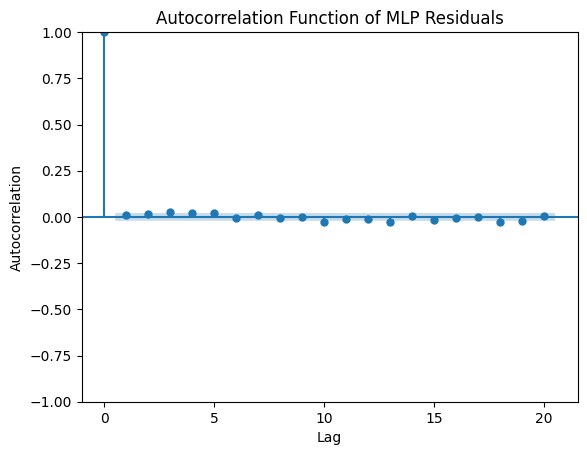

MAE      RMAE
horizonte 1h  0.063205  0.095438

In [100]:
df_LSTM_one_error = pd.DataFrame(columns=['MAE','RMAE'])

horizonte = 1
df_test = prediccion(horizonte)

df_plot = pd.DataFrame()
df_plot['Time'] = df_test['Time']
df_plot['Prediction'] = df_test[f"horizonte {horizonte}"].values
df_plot['Power'] = df_test['Power'].values

fig = pl.line(df_plot, x='Time', y=['Power', 'Prediction'])
fig.show()

# Obtener residuos del modelo MLP
residuals = df_plot['Power'] - df_plot['Prediction']

# Calcular la función de autocorrelación de los residuos
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of MLP Residuals')
plt.show()

df_LSTM_one_error

In [ ]:
# Obtener residuos del modelo MLP
residuals = df_plot['Power'] - df_plot['Prediction']

# Calcular la función de autocorrelación de los residuos
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of LSTM Residuals')
plt.show()

In [57]:
horizonte_prediccion = 5
column_name = f'+{horizonte_prediccion}h'

df_plot = pd.DataFrame()
df_plot['Tiempo'] = df_resultados.index
df_plot['Many to Many'] = df_resultados[column_name].values
#df_plot['Many to One'] = df_test[f"horizonte {horizonte}"].values
df_plot['Producción Real'] = df_resultados['Power'].values

df_comp = df_plot[4:].copy()
df_comp['Many to One'] = df_test[:-18][f"horizonte {horizonte}"].values

fig = pl.line(df_comp, x='Tiempo', y=['Producción Real', 'Many to Many', 'Many to One'])
fig.show()